### Sentinel-3 Level-2 altimetry data visualization.
#### Data download from: https://scihub.copernicus.eu/dhus/#/home


In [1]:
import matplotlib.pyplot as plt
from osgeo import gdal
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import h5py
from utils.geotif_io import readTiff
from utils.imgShow import imgShow


In [2]:
## s3 data
path_s3l2 = 'data/s3-altimetry/s3a-orbit-289/S3A_SR_2_LAN____20200523T030933_20200523T035741_20200617T203903_2888_058_289______LN3_O_NT_004.SEN3/enhanced_measurement.nc'
path_s3l2_subs = 'data/s3-altimetry/s3a-orbit-289/S3A_SR_2_LAN____20200523T030933_20200523T035741_20200617T203903_2888_058_289______LN3_O_NT_004.SEN3/enhanced_measurement_subs.nc'
path_s3l2_merge = 'data/s3-altimetry/s3a-orbit-289/enhanced_measurement_readout_subs_merge.h5'
## remote sensing data
path_rsimg = 'data/rs-img/dianchi_s2_20200511_wgs84.tif'
path_rsimg_wat = 'data/water_mask/dianchi_s2_20200511_wat_wgs84.tif'


### Data reading

In [3]:
!h5ls $path_s3l2_merge

cycle                    Dataset {143}
elevation_ocog_20_ku     Dataset {143}
lat_20_ku                Dataset {143}
lon_20_ku                Dataset {143}
pass                     Dataset {143}
time_20_ku               Dataset {143}
waveform_20_ku           Dataset {143, 128}


In [4]:
## 1. s3l2 altimetry data
s3_l2 = xr.open_dataset(path_s3l2)
s3_l2_subs = xr.open_dataset(path_s3l2_subs)
s3_l2_merge = xr.open_dataset(path_s3l2_merge)
## 2. remote sensing image
rs_img, rs_img_info = readTiff(path_rsimg)
rs_wat, rs_wat_info = readTiff(path_rsimg_wat)


### Visualization from global perspective

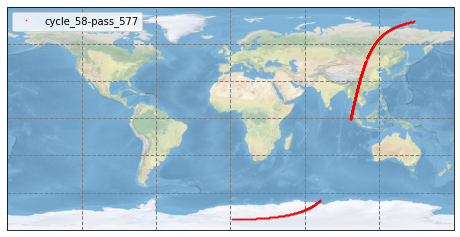

In [5]:
proj = ccrs.PlateCarree(central_longitude=0.0)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=proj); ax.stock_img()
orbit = 'cycle_'+str(s3_l2.attrs['cycle_number'])+'-pass_'+str(s3_l2.attrs['pass_number'])
ax.plot(s3_l2['lon_01'], s3_l2['lat_01'], marker='.', markersize=1, 
                                linewidth=0.0, label=orbit, color='red')
ax.gridlines(linewidth=1, color='gray', linestyle='--')
ax.legend()


### Visualization from local perspective

Text(0.5, 1.0, 'Surface water map')

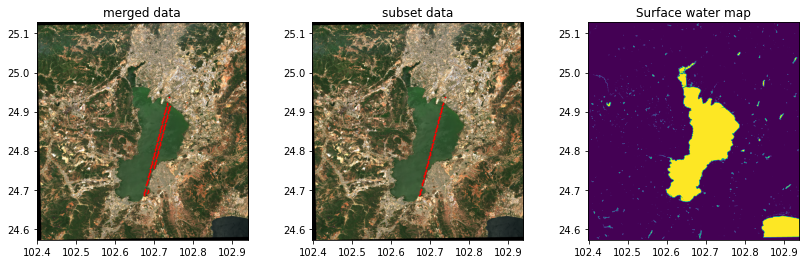

In [6]:
fig = plt.figure(figsize=(14, 4))
plt.subplot(1,3,1)
imgShow(rs_img, extent=rs_img_info['geoextent'])
plt.scatter(x=s3_l2_merge['lon_20_ku'], y=s3_l2_merge['lat_20_ku'], s=0.5, color='red')  ## altimetry data
plt.title('merged data')

plt.subplot(1,3,2)
imgShow(rs_img, extent=rs_img_info['geoextent'])
plt.scatter(x=s3_l2_subs['lon_20_ku'], y=s3_l2_subs['lat_20_ku'], s=0.5, color='red')  ## altimetry data
plt.title('subset data')

plt.subplot(1, 3, 3)
imgShow(rs_wat, extent=rs_wat_info['geoextent'])
plt.title('Surface water map')
